In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim import optimizer

import matplotlib.pyplot as plt
pd.options.display.max_columns = None
pd.options.display.max_rows = 50
pd.options.display.min_rows = 20

%matplotlib notebook

In [2]:
crop_yield_data = pd.read_csv('yield_forecasting_database_0718.csv', parse_dates=['Date', ], dayfirst=True)

In [3]:
crop_yield_data

,Unnamed: 0,Vineyard_name,Block_name,Season,Date,Variety,NDVImean,NDVIsum,NDWImean,NDWIsum,NDVIRemean,NDVIResum,TCARImean,TCARIsum,SIPImean,SIPIsum,RRENDVImean,RRENDVIsum,RN2NDVImean,RN2NDVIsum,GNDVImean,GNDVIsum,MSRmean,MSRsum,RVImean,RVIsum,N2NDVImean,N2NDVIsum,RENDVI1mean,RENDVI1sum,RENDVI2mean,RENDVI2sum,RDVI1mean,RDVI1sum,RDVI2mean,RDVI2sum,TDVImean,TDVIsum,TDVI2mean,TDVI2sum,NLImean,NLIsum,LAIGmean,LAIGsum,SMmean,SMsum,GDD,Rainfall,Yield,Size,Ha,SizeClass,TimeTo,BlockAverage,VineyardVarietyAverage,HeatShock,FrostShock,MaxSize,PC1,PC2,Cabernet Sauvignon,Chardonnay,Marzemino,Merlot,Pinot Gris,Pinot Noir,Rare Red,Rare White,Riesling,Sauvignon Blanc,Sauvignon Gris,Syrah,YieldPerHec,YieldScale,High yield,Low yield,variety_idx,New_Longitude,New_Latitude
0,0,M33,M33SGRA,2017,2017-03-02,Sauvignon Gris,0.740918,700.908104,0.179463,169.771876,0.392568,371.368954,0.134938,127.650903,0.773903,732.112067,0.636275,601.916582,0.411498,389.276928,0.703271,665.294836,2.099081,1985.730419,6.987541,6610.213904,0.755095,714.319960,0.495762,468.991177,0.519476,491.424471,0.417432,394.890273,0.755095,714.319960,0.449033,424.785153,0.479682,453.779054,0.304651,288.199580,2.693769,2548.305267,0.453149,428.679313,802.0,636.0,43.366,946,938,Large,60,71.1690,78.268693,-1,-1,946,538.980888,12.244786,0,0,0,0,0,0,0,0,0,0,1,0,0.046232,Low yield,0,1,1,6.915636,45.922095
1,1,M33,M00BGFA,2017,2017-03-02,Pinot Gris,0.786083,517.242711,0.227985,150.013921,0.419335,275.922326,0.115664,76.107160,0.808175,531.779090,0.682158,448.859642,0.426194,280.435943,0.742054,488.271269,2.440964,1606.154376,8.625850,5675.809354,0.797466,524.732863,0.550287,362.088926,0.571382,375.969473,0.426074,280.356626,0.797466,524.732863,0.447189,294.250330,0.475947,313.172921,0.377381,248.316547,2.974321,1957.103000,0.632657,416.288583,802.0,636.0,42.980,658,652,Large,60,39.4806,93.506950,-1,-1,658,250.343140,14.076773,0,0,0,0,1,0,0,0,0,0,0,0,0.065920,Low yield,0,1,2,6.915636,45.922095
2,2,M33,C77IGMB,2017,2017-03-02,Pinot Gris,0.717883,1178.046488,0.158046,259.354077,0.363956,597.251994,0.121078,198.688195,0.759261,1245.947982,0.619473,1016.555458,0.403750,662.553521,0.698036,1145.476805,1.946544,3194.278044,6.311958,10357.923600,0.732991,1202.838505,0.483077,792.729407,0.507368,832.590514,0.389719,639.529677,0.732991,1202.838505,0.407882,669.334501,0.437265,717.552373,0.219227,359.752223,2.628323,4313.077726,0.511516,839.397052,802.0,636.0,212.083,1641,1629,XLarge,60,205.1076,93.506950,-1,-1,1641,1293.231233,29.758541,0,0,0,0,1,0,0,0,0,0,0,0,0.130192,Low yield,0,1,2,6.915636,45.922095
3,3,M33,J44POPD,2017,2017-03-02,Pinot Noir,0.732823,416.976093,0.182909,104.075383,0.377717,214.921125,0.110960,63.136513,0.755454,429.853453,0.634073,360.787657,0.407067,231.621229,0.693608,394.662719,2.104537,1197.481818,7.117464,4049.837023,0.747063,425.079037,0.501624,285.424225,0.525769,299.162791,0.386557,219.951134,0.747063,425.079037,0.397065,225.929852,0.425234,241.957877,0.235094,133.768424,2.727784,1552.108886,0.647480,368.416269,802.0,636.0,22.520,569,568,Large,60,27.3124,24.258222,-1,-1,569,103.733773,8.197270,0,0,0,0,0,1,0,0,0,0,0,0,0.039648,Low yield,0,1,3,6.915636,45.922095
4,4,M33,Q11WVWL,2017,2017-03-02,Pinot Noir,0.782788,439.926718,0.234459,131.765965,0.421701,236.995732,0.132387,74.401442,0.804453,452.102493,0.677133,380.548669,0.427313,240.150129,0.728956,409.673091,2.413730,1356.516332,8.485446,4768.820929,0.792497,445.383408,0.542648,304.968251,0.560589,315.051124,0.447649,251.578519,0.792497,445.383408,0.487539,273.996979,0.513172,288.402751,0.413861,232.589632,2.915985,1638.783326,0.510686,287.005621,802.0,636.0,22.260,562,557,Large,60,24.1448,24.258222,-1,-1,562,131.609356,7.079762,0,0,0,0,0,1,0,0,0,0,0,0,0.039964,Low yield,0,1,3,6.915636,45.922095
5,5,M33,X88EDEU,2017,2017-03-02,Pinot Noir,0.822291,790.221870,0.244260,234.733404,0.490406,471.280430,0.127612,122.635022,0.834475,801.930427,0.705930,678.398868,0.437736,420.664484,0.750745,721.465705,2.870665,2758.709390,11.2

In [4]:
from scipy.stats import norm
def gaussianize(data):
    n = data.shape[0]
    indices = np.argsort(data)
    qs = norm.ppf(np.linspace(1/n, 1 - 1/n, n))
    return qs[indices]

crop_yield_data['YieldGaussian'] = gaussianize(crop_yield_data.Yield.to_numpy())
    

<IPython.core.display.Javascript object>


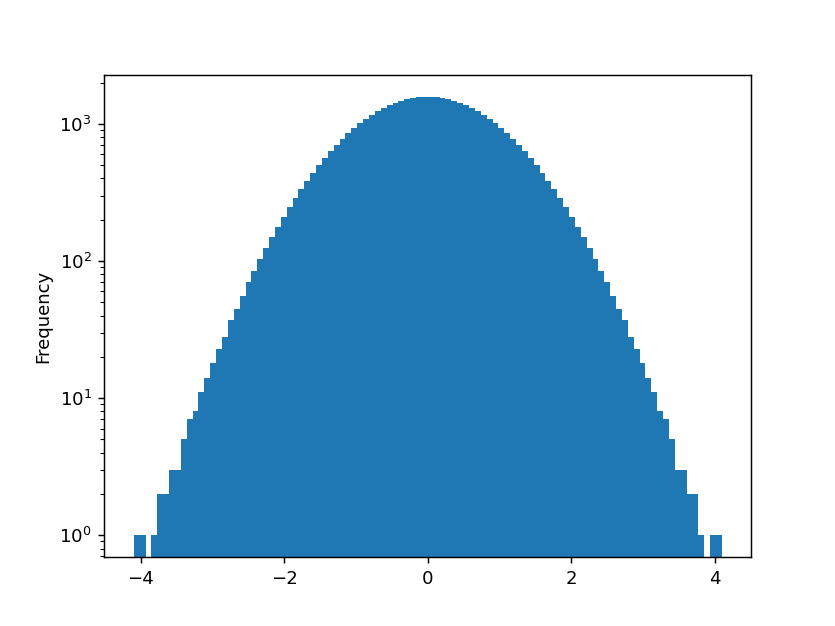

<Axes: ylabel='Frequency'>

In [5]:
((crop_yield_data.YieldGaussian)).plot.hist(bins=100, log=True)

In [6]:
crop_yield_data[crop_yield_data.Block_name == 'M33SGRA'].sort_values('Date')

,Unnamed: 0,Vineyard_name,Block_name,Season,Date,Variety,NDVImean,NDVIsum,NDWImean,NDWIsum,NDVIRemean,NDVIResum,TCARImean,TCARIsum,SIPImean,SIPIsum,RRENDVImean,RRENDVIsum,RN2NDVImean,RN2NDVIsum,GNDVImean,GNDVIsum,MSRmean,MSRsum,RVImean,RVIsum,N2NDVImean,N2NDVIsum,RENDVI1mean,RENDVI1sum,RENDVI2mean,RENDVI2sum,RDVI1mean,RDVI1sum,RDVI2mean,RDVI2sum,TDVImean,TDVIsum,TDVI2mean,TDVI2sum,NLImean,NLIsum,LAIGmean,LAIGsum,SMmean,SMsum,GDD,Rainfall,Yield,Size,Ha,SizeClass,TimeTo,BlockAverage,VineyardVarietyAverage,HeatShock,FrostShock,MaxSize,PC1,PC2,Cabernet Sauvignon,Chardonnay,Marzemino,Merlot,Pinot Gris,Pinot Noir,Rare Red,Rare White,Riesling,Sauvignon Blanc,Sauvignon Gris,Syrah,YieldPerHec,YieldScale,High yield,Low yield,variety_idx,New_Longitude,New_Latitude,YieldGaussian
52,52,M33,M33SGRA,2017,2016-12-15,Sauvignon Gris,0.695693,658.125485,0.190022,179.760968,0.342844,324.330532,0.154927,146.561099,0.732190,692.651797,0.601059,568.601610,0.406552,384.598209,0.644774,609.956083,1.800017,1702.816159,5.671337,5365.084836,0.699946,662.149272,0.465408,440.275924,0.471803,446.325440,0.422892,400.055451,0.699946,662.149272,0.476716,450.973252,0.485068,458.874634,0.273183,258.431136,2.436094,2304.545003,0.353862,334.753747,342.0,435.6,43.366,946,938,Large,137,71.169,78.268693,-1,-1,946,475.714032,-12.803522,0,0,0,0,0,0,0,0,0,0,1,0,0.046232,Low yield,0,1,1,6.915636,45.922095,0.193732
104,104,M33,M33SGRA,2017,2016-12-25,Sauvignon Gris,0.755459,714.664498,0.267472,253.028268,0.415240,392.817435,0.158665,150.097107,0.795668,752.701926,0.645676,610.809458,0.421224,398.478015,0.690262,652.987532,2.206585,2087.429826,7.488509,7084.129679,0.763944,722.690719,0.500886,473.837687,0.515580,487.739064,0.451519,427.137071,0.763944,722.690719,0.505288,478.002062,0.525650,497.264581,0.388080,367.124047,2.672712,2528.385642,0.524281,495.969375,392.5,449.6,43.366,946,938,Large,127,71.169,78.268693,-1,-1,946,549.122025,-8.026063,0,0,0,0,0,0,0,0,0,0,1,0,0.046232,Low yield,0,1,1,6.915636,45.922095,-0.446286
207,207,M33,M33SGRA,2017,2017-02-03,Sauvignon Gris,0.574667,543.634971,0.180477,170.731018,0.193200,182.766734,0.095306,90.159044,0.620095,586.610145,0.521778,493.602243,0.357025,337.745981,0.566496,535.905293,1.256907,1189.033800,3.754974,3552.205117,0.587738,556.000278,0.430349,407.109746,0.446375,422.270948,0.338811,320.515535,0.587738,556.000278,0.372072,351.980338,0.390865,369.758101,0.010372,9.812053,2.298658,2174.530475,0.524678,496.345781,621.0,572.0,43.366,946,938,Large,87,71.169,78.268693,-1,-1,946,339.016096,-5.146910,0,0,0,0,0,0,0,0,0,0,1,0,0.046232,Low yield,0,1,1,6.915636,45.922095,-0.083509
78,78,M33,M33SGRA,2017,2017-02-10,Sauvignon Gris,0.705106,667.030032,0.177348,167.771269,0.348521,329.700913,0.140252,132.678054,0.766041,724.674701,0.610881,577.893278,0.400442,378.817820,0.691818,654.459586,1.881222,1779.635960,6.060731,5733.451105,0.719629,680.768938,0.478136,452.317118,0.500502,473.474630,0.418086,395.509276,0.719629,680.768938,0.464328,439.254337,0.494056,467.377254,0.273889,259.099043,2.591212,2451.286375,0.372948,352.808672,660.0,578.9,43.366,946,938,Large,80,71.169,78.268693,-1,-1,946,523.265457,13.555551,0,0,0,0,0,0,0,0,0,0,1,0,0.046232,Low yield,0,1,1,6.915636,45.922095,2.479045
233,233,M33,M33SGRA,2017,2017-02-13,Sauvignon Gris,0.723145,684.095326,0.192026,181.656809,0.346268,327.569870,0.111450,105.431658,0.762061,720.909960,0.633212,599.018107,0.405216,383.333902,0.704266,666.235417,2.007739,1899.320841,6.634820,6276.540101,0.737754,697.915218,0.509779,482.251274,0.532752,503.983806,0.397229,375.778644,0.737754,697.915218,0.419468,396.816793,0.448739,424.507328,0.246720,233.397004,2.765527,2616.188471,0.573426,542.461077,680.0,579.7,43.366,946,938,Large,77,71.169,78.268693,-1,-1,946,529.571435,19.854876,0,0,0,0,0,0,0,0,0,0,1,0,0.046232,Low yield,0,1,1,6.915636,45.922095,-0.077500
26,26,M33,M33SGRA,2017,2017-02-20,Sauvignon Gris,0.754352,713.617334,0.207925,196.697134,0.412253,389.991642,0.134984,127.694999,0.801215,757.949662

In [7]:
crop_yield_data[crop_yield_data.Block_name == 'M33SGRA'].sort_values('Date').Date

52     2016-12-15
104    2016-12-25
207    2017-02-03
78     2017-02-10
233    2017-02-13
26     2017-02-20
130    2017-02-23
0      2017-03-02
156    2017-03-05
259    2017-03-15
          ...    
2572   2021-02-04
3030   2021-02-07
2978   2021-02-09
3004   2021-02-17
3056   2021-02-19
3134   2021-02-27
2774   2021-03-04
2904   2021-03-06
2930   2021-03-14
2754   2021-03-16
Name: Date, Length: 127, dtype: datetime64[ns]

In [8]:
data_frost = crop_yield_data[crop_yield_data.FrostShock == 1]
data_frost.sort_values('Date')

,Unnamed: 0,Vineyard_name,Block_name,Season,Date,Variety,NDVImean,NDVIsum,NDWImean,NDWIsum,NDVIRemean,NDVIResum,TCARImean,TCARIsum,SIPImean,SIPIsum,RRENDVImean,RRENDVIsum,RN2NDVImean,RN2NDVIsum,GNDVImean,GNDVIsum,MSRmean,MSRsum,RVImean,RVIsum,N2NDVImean,N2NDVIsum,RENDVI1mean,RENDVI1sum,RENDVI2mean,RENDVI2sum,RDVI1mean,RDVI1sum,RDVI2mean,RDVI2sum,TDVImean,TDVIsum,TDVI2mean,TDVI2sum,NLImean,NLIsum,LAIGmean,LAIGsum,SMmean,SMsum,GDD,Rainfall,Yield,Size,Ha,SizeClass,TimeTo,BlockAverage,VineyardVarietyAverage,HeatShock,FrostShock,MaxSize,PC1,PC2,Cabernet Sauvignon,Chardonnay,Marzemino,Merlot,Pinot Gris,Pinot Noir,Rare Red,Rare White,Riesling,Sauvignon Blanc,Sauvignon Gris,Syrah,YieldPerHec,YieldScale,High yield,Low yield,variety_idx,New_Longitude,New_Latitude,YieldGaussian
47344,47344,BU3,FY2BSFU,2021,2020-10-20,Pinot Gris,0.525133,338.710486,0.000139,0.089727,0.209602,135.193149,0.153036,98.708229,0.596939,385.025811,0.466468,300.871921,0.342148,220.685438,0.541561,349.306806,1.080473,696.905190,3.225223,2080.269086,0.529440,341.488902,0.354916,228.920895,0.360082,232.252711,0.355075,229.023128,0.529440,341.488902,0.421442,271.830178,0.427761,275.906025,0.056320,36.326314,1.832242,1181.795902,0.038905,25.093818,26.5,84.9,22.810,645,641,Large,193,38.1366,26.422829,0,1,645,40.569961,-4.271086,0,0,0,0,1,0,0,0,0,0,0,0,0.035585,Low yield,0,1,2,5.532280,44.451671,1.433761
47340,47340,BU3,TN6POPI,2021,2020-10-20,Pinot Noir,0.431680,170.945211,-0.103926,-41.154730,0.155896,61.734835,0.115496,45.736579,0.521105,206.357565,0.390654,154.699154,0.300013,118.805327,0.478411,189.450828,0.810630,321.009334,2.522630,998.961447,0.435531,172.470276,0.295796,117.135171,0.300119,118.847101,0.278699,110.364682,0.435531,172.470276,0.320889,127.072229,0.325510,128.901948,-0.141717,-56.120051,1.508143,597.224579,0.049610,19.645581,26.5,84.9,3.868,396,393,Med,193,21.8344,25.383767,0,1,396,-219.849502,-0.851664,0,0,0,0,0,1,0,0,0,0,0,0,0.009842,Low yield,0,1,3,5.532280,44.451671,-1.184832
47339,47339,BU3,FY2BZBZ,2021,2020-10-20,Pinot Noir,0.456507,167.538088,-0.090093,-33.064147,0.162920,59.791809,0.114343,41.964011,0.553699,203.207529,0.412862,151.520471,0.308924,113.374944,0.511450,187.702044,0.879108,322.632816,2.695147,989.118825,0.466846,171.332552,0.317632,116.570973,0.329515,120.931866,0.293418,107.684461,0.466846,171.332552,0.337465,123.849583,0.350879,128.772558,-0.106373,-39.038768,1.667027,611.798738,0.051270,18.815944,26.5,84.9,19.005,367,364,Med,193,20.2894,25.383767,0,1,367,-225.125785,2.355441,0,0,0,0,0,1,0,0,0,0,0,0,0.052212,Low yield,0,1,3,5.532280,44.451671,-1.170764
47337,47337,BU3,QK8MLMH,2021,2020-10-20,Pinot Noir,0.426716,657.996455,-0.095191,-146.784443,0.152736,235.519531,0.111014,171.183905,0.520607,802.776362,0.386910,596.615009,0.297304,458.442668,0.480616,741.109617,0.807997,1245.931118,2.540820,3917.944523,0.430058,663.149189,0.294769,454.533917,0.298195,459.816197,0.275115,424.227499,0.430058,663.149189,0.316476,488.005684,0.319817,493.157692,-0.149537,-230.585342,1.497742,2309.518547,0.066183,102.054842,26.5,84.9,22.687,1542,1532,XLarge,193,83.5080,25.383767,0,1,1542,660.410858,0.682501,0,0,0,0,0,1,0,0,0,0,0,0,0.014809,Low yield,0,1,3,5.532280,44.451671,-1.175427
48075,48075,EX5,PJ6LKDB,2021,2020-10-20,Pinot Noir,0.402944,45.129691,-0.092975,-10.413167,0.126554,14.174011,0.089973,10.076988,0.494620,55.397488,0.370939,41.545121,0.280075,31.368362,0.457125,51.198043,0.745049,83.445511,2.383400,266.940776,0.420920,47.143065,0.292256,32.732701,0.312093,34.954363,0.255444,28.609732,0.420920,47.143065,0.290545,32.541023,0.311671,34.907199,-0.203058,-22.742481,1.572860,176.160331,0.110007,12.320732,26.5,84.9,4.216,112,113,Small,193,24.8244,19.795857,0,1,112,-442.347989,0.696600,0,0,0,0,0,1,0,0,0,0,0,0,0.037310,Low yield,0,1,3,5.581998,44.523091,0.055054
48074,48074,EX5,IC9EDEV,2021,2020-10-20,Pinot Noir,0.445257,95.284963,-0.119533,-25.580011,0.144271,30.873998,0.096498,20.650649,0.538913,115.327369,0.407182,87.136957,0.303058,64.8543

From the above it looks like the only season with a Frost shock was 2021. As such we will discard data with frost shock for now.

<IPython.core.display.Javascript object>


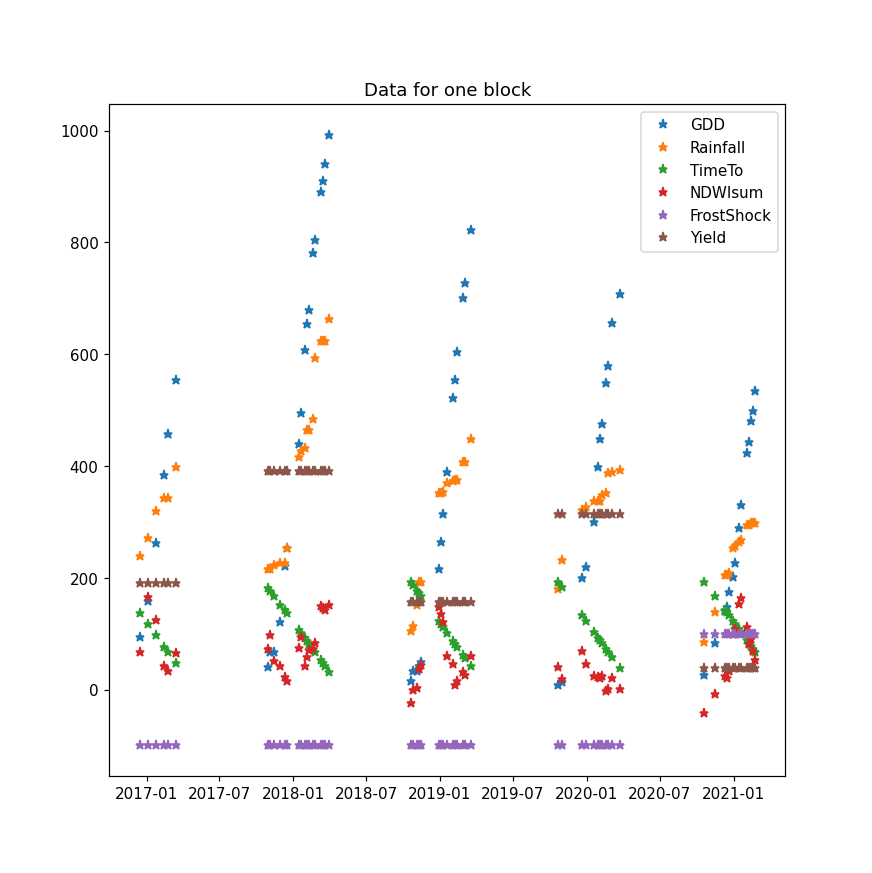

Text(0.5, 1.0, 'Data for one block')

In [9]:
%matplotlib notebook

data_block = crop_yield_data[crop_yield_data.Block_name == 'TN6POPI'].sort_values('Date')

plt.figure(figsize=(8, 8))
plt.plot(data_block.Date.to_numpy(), data_block.GDD.to_numpy(), '*', label='GDD')
plt.plot(data_block.Date.to_numpy(), data_block.Rainfall.to_numpy(),  '*', label='Rainfall')
plt.plot(data_block.Date.to_numpy(), data_block.TimeTo.to_numpy(),  '*', label='TimeTo')
plt.plot(data_block.Date.to_numpy(), data_block.NDWIsum.to_numpy(),  '*', label='NDWIsum')
plt.plot(data_block.Date.to_numpy(), data_block.FrostShock.to_numpy() * 100, '*', label='FrostShock')

plt.plot(data_block.Date.to_numpy(), data_block.Yield.to_numpy() * 10,  '*', label='Yield')

plt.legend()
plt.title('Data for one block')

## Basic model 

For our first model we will only use a handfull of features, specifically:
1. GDD: this indicator is related to the amount of sun
2. Rainfall: indicator for the amount of rain
3. TimeTo: time until harvesting
4. HeatShock, Frostshock: indicators of temperature shocks
5. High yield / Low yield: important feature as it determines the method of growth

In [10]:
feature_names = ['GDD', 'Rainfall', 
                 'TimeTo', 'High yield', 'Size',
                'PC1', 'PC2', 'NDVImean', 'NDWImean',
                'Cabernet Sauvignon', 'Chardonnay', 'Marzemino', 'Merlot', 'Pinot Gris',
                'Pinot Noir', 'Rare Red', 'Riesling', 'Sauvignon Blanc', 'Sauvignon Gris',
                'Syrah'
                ]

In [11]:
from typing import List
from datetime import datetime
from torch.nn import Sequential, Linear, ReLU, BatchNorm1d
from tukey.losses import TuckeyGandHloss

def convert_dataset_to_tensor(pd_data: pd.DataFrame, feature_names: List[str], target_name: str,
                             log_target: bool = True, mean_features: float = None,
                              std_features: float = None):
    features = pd_data[feature_names]
    targets = pd_data[target_name]
    features_torch = torch.from_numpy(features.to_numpy()).to(dtype=torch.float32)
    targets_torch = torch.from_numpy(targets.to_numpy()).to(dtype=torch.float32)
    # apply transformations
    if log_target:
        targets_torch = torch.log(targets_torch)
    else:
        targets_torch = targets_torch
    # compute mean and std for training data
    if mean_features is None:
        mean = torch.mean(features_torch, dim=0, keepdims=True)
        std = torch.std(features_torch, dim=0, keepdims=True)
        features_torch = (features_torch - mean) / std
        return (features_torch, targets_torch), (mean, std)
    # for new data apply mean and std from train data
    features_torch = (features_torch - mean_features) / std_features
    return features_torch, targets_torch

def split_train_test(pd_data: pd.DataFrame, split_date: str):
    split_date = datetime.fromisoformat(split_date)
    train, test = pd_data[pd_data.Date <= split_date], pd_data[pd_data.Date > split_date]
    return train, test


class NN(Sequential):
    def __init__(self, structure: list, n_out: int):
        subblocks = []
        self.n_out = n_out
        for i in range(len(structure) - 1):
            subblocks.extend(self._make_sublock(structure[i], structure[i + 1]))
        subblocks.extend(self._make_final_layer(structure[-1]))
        super().__init__(*subblocks)

    def _make_sublock(self, n_in: int, n_out: int):
        return [Linear(n_in, n_out), ReLU(), ] #BatchNorm1d(n_out)]

    def _make_final_layer(self, n_in : int):
        return [Linear(n_in, self.n_out), ]

    
def train_for_one_epoch(nn, optimizer, train_dataset: Dataset, val_dataset: Dataset):
    nn.train()
    dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    losses = []
    losses_gaussian = []
    for x, y in dataloader:
        optimizer.zero_grad()
        y_hat = nn(x)
        loss_y_yhat = loss(y_hat, y)
        loss_y_yhat.backward()
        optimizer.step()
        losses.append(loss_y_yhat.detach().item())
    print('Train losses: ', np.mean(losses))
    
    nn.eval()
    dataloader_val = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    losses = []
    losses_gaussian = []
    with torch.no_grad():
        for x, y in dataloader_val:
            y_hat = nn(x)
            loss_y_yhat = loss(y_hat, y)
            losses.append(loss_y_yhat.detach().item())
    print('Validation losses: ', np.mean(losses))

In [12]:
train, test = split_train_test(crop_yield_data[crop_yield_data.FrostShock < 0], '2020-02-01')
train_torch, mean_std = convert_dataset_to_tensor(train[train.TimeTo < 100], feature_names, 'YieldPerHec', True)
test_torch = convert_dataset_to_tensor(test[test.TimeTo < 40], feature_names, 'YieldPerHec', True, *mean_std)

In [13]:
mean_std

(tensor([[6.4483e+02, 7.6641e+02, 7.0634e+01, 5.1060e-01, 5.1066e+02, 4.3816e+01,
          4.9851e+00, 7.0781e-01, 2.1468e-01, 2.2275e-02, 1.0294e-01, 9.3714e-04,
          4.3253e-03, 5.1759e-02, 2.3169e-01, 1.3769e-02, 1.7013e-02, 5.0966e-01,
          3.6693e-02, 8.1459e-03]]),
 tensor([[2.9176e+02, 2.7195e+02, 1.8185e+01, 4.9991e-01, 3.6900e+02, 4.2002e+02,
          1.0173e+01, 1.1900e-01, 1.1979e-01, 1.4758e-01, 3.0389e-01, 3.0599e-02,
          6.5627e-02, 2.2155e-01, 4.2193e-01, 1.1653e-01, 1.2932e-01, 4.9992e-01,
          1.8801e-01, 8.9890e-02]]))

In [14]:
from torch.optim import Adam
nn = NN((len(feature_names), 128, 256, 512), 4)  # 4 outputs required for G-and-H
optimizer = Adam(nn.parameters(), lr=1e-4)

In [15]:
train_torch[1]

tensor([-3.0741, -2.7193, -2.0387,  ..., -2.5607, -1.2565, -2.8751])

Train losses:  0.17779927061629797
Validation losses:  -0.190061038484176


<IPython.core.display.Javascript object>


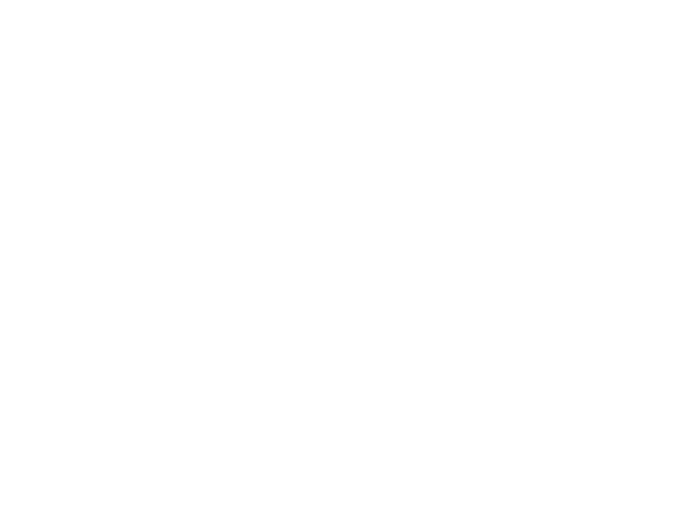

<IPython.core.display.Javascript object>


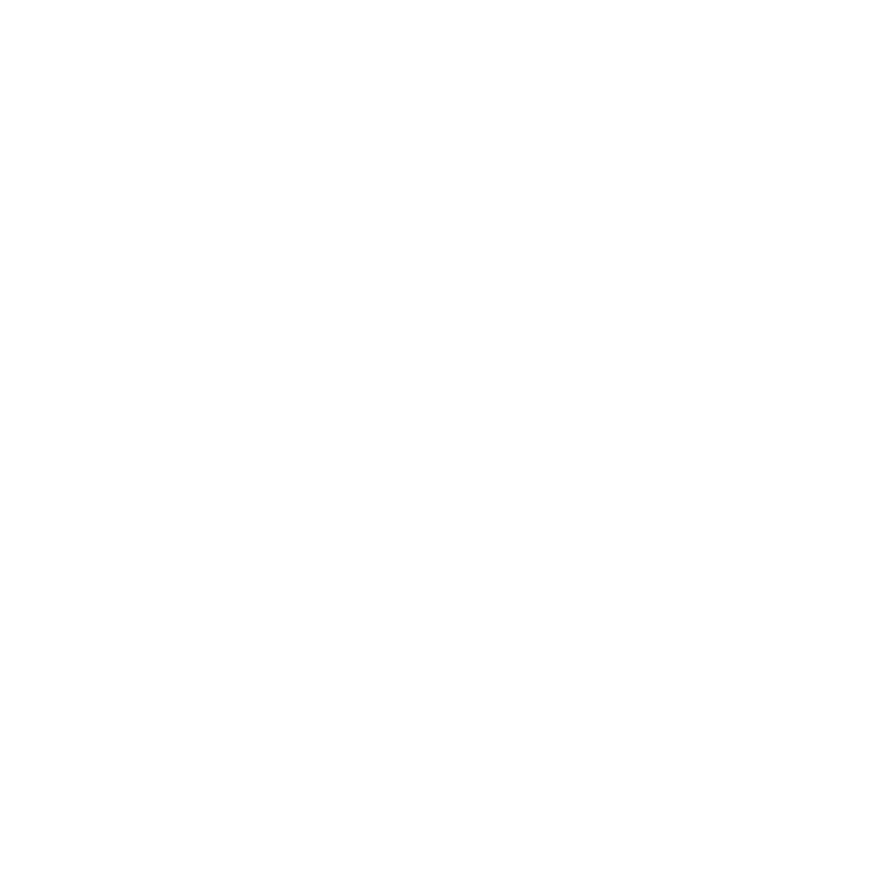

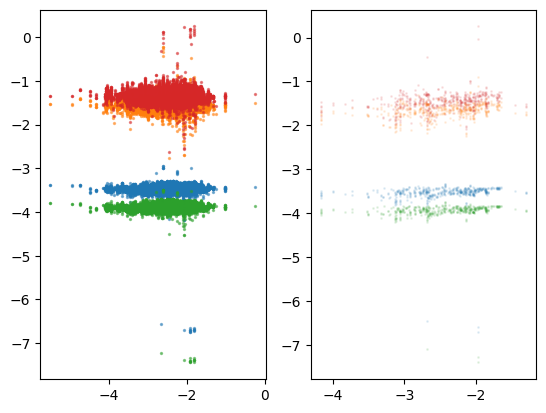

Train losses:  -0.22087630962492688
Validation losses:  -0.16987562055389085


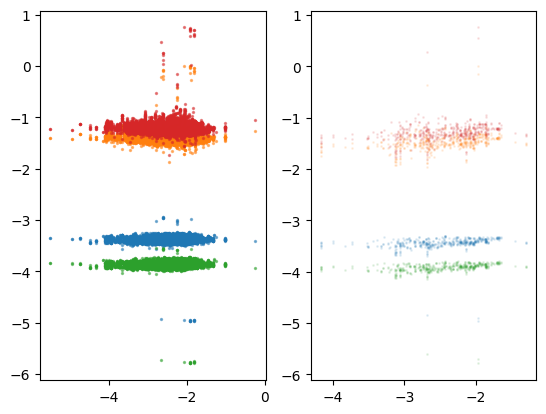

In [ ]:
%matplotlib inline

N_EPOCHS = 200
BATCH_SIZE = 32
DEVICE = 'cuda:0'
loss = TuckeyGandHloss(n_target_channels=1, gmax=0.3, hmax=0.)

nn = nn.to(device=DEVICE)
train_torch = tuple([v.to(device=DEVICE) for v in train_torch])
test_torch = tuple([v.to(device=DEVICE) for v in test_torch])


for i_epoch in range(N_EPOCHS):
    epoch_loss = train_for_one_epoch(nn, optimizer, TensorDataset(*train_torch), TensorDataset(*test_torch))
    nn.eval()
    fig = plt.figure()
    with torch.no_grad():
        y_train = nn(train_torch[0])
        pred_ci95 = loss.predict_ci(y_train)
        pred_ci99 = loss.predict_ci(y_train, alpha=0.99)
    ax = fig.add_subplot(1, 2, 1)
    ax.scatter(train_torch[1].cpu(), pred_ci95[0].cpu(), alpha=0.5, s=2)
    ax.scatter(train_torch[1].cpu(), pred_ci95[1].cpu(), alpha=0.5, s=2)
    ax.scatter(train_torch[1].cpu(), pred_ci99[0].cpu(), alpha=0.5, s=2)
    ax.scatter(train_torch[1].cpu(), pred_ci99[1].cpu(), alpha=0.5, s=2)
    with torch.no_grad():
        pred_ci95 = loss.predict_ci(nn(test_torch[0]))
        pred_ci99 = loss.predict_ci(nn(test_torch[0]), alpha=0.99)
    ax = fig.add_subplot(1, 2, 2)
    ax.scatter(test_torch[1].cpu(), pred_ci95[0].cpu(), alpha=0.1, s=1)
    ax.scatter(test_torch[1].cpu(), pred_ci95[1].cpu(), alpha=0.1, s=1)
    ax.scatter(test_torch[1].cpu(), pred_ci99[0].cpu(), alpha=0.1, s=1)
    ax.scatter(test_torch[1].cpu(), pred_ci99[1].cpu(), alpha=0.1, s=1)
    plt.show()
    plt.pause(0.1)


Now we look at some predictions on the validation dataset

In [ ]:
with torch.no_grad():
    pred = loss.predict(nn(train_torch[0]))
    pred = torch.cat(pred, dim=1)
    ci = loss.predict_ci(nn(train_torch[0]))

In [ ]:
pred

In [ ]:
ci

In [ ]:
plt.figure()
plt.scatter(train_torch[1], pred[:, 0])

In [ ]:
plt.figure()
plt.hist(pred[:, 0])

In [ ]:
train_torch[0][:10], train_torch[1][:10]

In [ ]:
test_torch[0][:10], test_torch[1][:10]

In [ ]:
test[:100][feature_names]

In [ ]:
test[:100].YieldPerHec